## set up AWA environment and vocs

In [1]:
from plugins.environments.awa_environment import AWAEnvironment
from plugins.interfaces.awa_interface import AWAInterface

# import data from csv file
import pandas as pd
variable_file = "plugins/environments/awa_variables.csv"
observable_file = "plugins/environments/awa_observables.csv"

env = AWAEnvironment(variable_file, observable_file, interface=AWAInterface(), target_charge=1.0)

In [2]:
env.variables

{'AWA:Drive:DS1:Ctrl': [500.0, 550.0],
 'AWA:Drive:DS3:Ctrl': [180.0, 260.0],
 'AWA:Bira3Ctrl:Ch03': [-5.0, 5.0],
 'AWA:Bira3Ctrl:Ch04': [-5.0, 5.0],
 'AWA:Bira3Ctrl:Ch05': [-5.0, 5.0],
 'AWA:Bira3Ctrl:Ch06': [-5.0, 5.0],
 'AWALLRF:K1:SetPhase': [339.0, 359.0],
 'AWA:DAC0:Ch08': [4.5, 5.9]}

In [3]:
from xopt import Xopt, Evaluator, VOCS
from xopt.generators.bayesian import BayesianExplorationGenerator, UpperConfidenceBoundGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from xopt.generators.bayesian.turbo import SafetyTurboController, OptimizeTurboController

import time

def evaluate(inputs):
    env.set_variables(inputs)
    time.sleep(2.0)
    result = env.get_observables(["13ARV1:Sx"])
    result["total_rms_size"] = (result["13ARV1:Sx"]**2 + result["13ARV1:Sy"]**2)**0.5
    return result

# use only one variable
vocs = VOCS(variables=env.variables,
            objectives={"total_rms_size":"MINIMIZE"},
            constraints={
                "13ARV1:bb_penalty":["LESS_THAN",0.0],
                "13ARV1:log10_total_intensity":["GREATER_THAN", 5.5]
            })


### get best point from old data

In [4]:
import yaml
import numpy as np
folder = "analysis/nn_prior/"
f_names = ["exploration_2_nd_filter.yml", "optimization_1.yml", "optimization_2.yml"]
dfs = []
for name in f_names:
    with open(folder + name, "r") as file:
        f = yaml.safe_load(file)
        dfs += [pd.DataFrame(f["data"])]

data = pd.concat(dfs, ignore_index=True)
data = data.dropna(subset=["total_rms_size"])
data["total_rms_size"] = data["total_rms_size"] - 57.224

old_vocs = VOCS(**f["vocs"])

old_best_x = data.iloc[np.nanargmin(data["total_rms_size"].to_numpy())][vocs.variable_names]

# account for phase drift 103 deg
old_best_x["AWALLRF:K1:SetPhase"] = old_best_x["AWALLRF:K1:SetPhase"] + 103
old_best_x = pd.DataFrame(old_best_x).T

### import nn prior model

In [5]:
import torch
class TransformedModel(torch.nn.Module):
    def __init__(self, model, x_transformer, y_transformer):
        super(TransformedModel, self).__init__()
        self.model = model
        self.x_transformer = x_transformer
        self.y_transformer = y_transformer
    
    def forward(self, x):
        x = self.x_transformer(x)
        x = self.model(x)
        x = self.y_transformer.untransform(x)
        return x

# wrap in AWA model to perform scaling
class AWAModel(torch.nn.Module):
    def __init__(self, base_model):
        super(AWAModel, self).__init__()
        self.model = base_model
        
    def forward(self, x):
        #add phase
        x[:,-1] = x[:,-1] - 103
        result = self.model(x).squeeze(dim=-1) + 57.224
        return result
    
nn_model = torch.load("analysis/nn_prior/fitted_model.pt")
awa_model = AWAModel(nn_model)


### Create Xopt object

In [6]:

model_constructor = StandardModelConstructor(
    use_low_noise_prior=False,
    #mean_modules={"total_rms_size":awa_model}
)
generator = UpperConfidenceBoundGenerator(
    vocs=vocs, 
    model_constructor=model_constructor,
    #turbo_controller=OptimizeTurboController(vocs=vocs, length=0.1)
)
generator.numerical_optimizer.n_raw_samples = 512
generator.numerical_optimizer.n_restarts = 512
generator.max_travel_distances = [0.25]*8
evaluator = Evaluator(function=evaluate)
X = Xopt(vocs=vocs, evaluator=evaluator, generator=generator)
X.options.dump_file = "run_data_2023_06_19/optimization_10_high_n_restarts_max_tvl.yml"

In [7]:
X


            Xopt
________________________________
Version: 1.4.1+50.ge9fc8ac.dirty
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: false, dump_file: run_data_2023_06_19/optimization_10_high_n_restarts_max_tvl.yml,
  max_evaluations: null}
generator:
  name: upper_confidence_bound
  model: null
  turbo_controller: null
  use_cuda: false
  model_constructor:
    name: standard
    use_low_noise_prior: false
    covar_modules: {}
    mean_modules: {}
    trainable_mean_keys: []
    dtype: torch.float64
    device: cpu
  numerical_optimizer: {name: LBFGS, n_raw_samples: 512, n_restarts: 512, max_iter: 2000}
  max_travel_distances: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
  n_monte_carlo_samples: 128
  beta: 2.0
evaluator:
  function: __main__.evaluate
  max_workers: 1
  function_kwargs: {}
  vectorized: false
vocs:
  variables:
    AWA:Drive:DS1:Ctrl: [500.0, 550.0]
    AWA:Drive:DS3:Ctrl: [180.0, 260.0]
    AWA:Bira3Ctrl:Ch03: [-5.0, 5.0]
    AWA:Bira3Ctrl:Ch04: [-5.0,

### Initialize w/ fixed initial points

In [8]:
# get the current quad setpoint
#current_val = env.get_variables(['AWA:Bira3Ctrl:Ch03'])
import numpy as np
default_pt = np.array([0, 0, 0, 0,5.9,550,190,349])
default_val = dict(zip(X.vocs.variable_names, default_pt))
default_val = pd.DataFrame(default_val, index=[0])
default_val

,AWA:Bira3Ctrl:Ch03,AWA:Bira3Ctrl:Ch04,AWA:Bira3Ctrl:Ch05,AWA:Bira3Ctrl:Ch06,AWA:DAC0:Ch08,AWA:Drive:DS1:Ctrl,AWA:Drive:DS3:Ctrl,AWALLRF:K1:SetPhase
0,0.0,0.0,0.0,0.0,5.9,550.0,190.0,349.0


In [9]:
# evaluate that point in xopt
X.evaluate_data(default_val)

CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:image1:ArrayData", Connecting to: 146.139.52.185:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Mon Jun 19 2023 17:00:17.899437837
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:image1:ArraySize1_RBV", Connecting to: 146.139.52.185:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Mon Jun 19 2023 17:00:17.899626367
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:image1:ArraySize0_RBV", Connecting to: 146.139.52.185:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Mon Jun 19 2023 17:00:17.899763949
................................................................

,AWA:Bira3Ctrl:Ch03,AWA:Bira3Ctrl:Ch04,AWA:Bira3Ctrl:Ch05,AWA:Bira3Ctrl:Ch06,AWA:DAC0:Ch08,AWA:Drive:DS1:Ctrl,AWA:Drive:DS3:Ctrl,AWALLRF:K1:SetPhase,AWAVXI11ICT:Ch1,13ARV1:image1:ArraySize1_RBV,...,13ARV1:Cx_std,13ARV1:Cy_std,13ARV1:Sx_std,13ARV1:Sy_std,13ARV1:bb_penalty_std,13ARV1:total_intensity_std,13ARV1:log10_total_intensity_std,total_rms_size,xopt_runtime,xopt_error
1,0.0,0.0,0.0,0.0,5.9,550.0,190.0,349.0,1.000543e-09,1200.0,...,0.636443,0.486935,4.923912,2.644505,11.298202,322535.126126,0.079834,64.658394,12.256959,False


In [10]:
# evaluate a second nearby point
second_pt = np.array([0.1, 0.1, 0.1, 0.1, 5.8,540,185,345])
second_pt = dict(zip(X.vocs.variable_names, second_pt))
second_pt = pd.DataFrame(second_pt, index=[0])
X.evaluate_data(second_pt)

,AWA:Bira3Ctrl:Ch03,AWA:Bira3Ctrl:Ch04,AWA:Bira3Ctrl:Ch05,AWA:Bira3Ctrl:Ch06,AWA:DAC0:Ch08,AWA:Drive:DS1:Ctrl,AWA:Drive:DS3:Ctrl,AWALLRF:K1:SetPhase,AWAVXI11ICT:Ch1,13ARV1:image1:ArraySize1_RBV,...,13ARV1:Cx_std,13ARV1:Cy_std,13ARV1:Sx_std,13ARV1:Sy_std,13ARV1:bb_penalty_std,13ARV1:total_intensity_std,13ARV1:log10_total_intensity_std,total_rms_size,xopt_runtime,xopt_error
2,0.1,0.1,0.1,0.1,5.8,540.0,185.0,345.0,9.819144e-10,1200.0,...,1.494389,0.475902,3.947269,0.195225,7.674018,150675.062932,0.033776,106.989584,7.972642,False


In [11]:
# evaluate old best_x
#X.evaluate_data(old_best_x)


### Run optimization

In [12]:
X.data

,AWA:Bira3Ctrl:Ch03,AWA:Bira3Ctrl:Ch04,AWA:Bira3Ctrl:Ch05,AWA:Bira3Ctrl:Ch06,AWA:DAC0:Ch08,AWA:Drive:DS1:Ctrl,AWA:Drive:DS3:Ctrl,AWALLRF:K1:SetPhase,AWAVXI11ICT:Ch1,13ARV1:image1:ArraySize1_RBV,...,13ARV1:Cx_std,13ARV1:Cy_std,13ARV1:Sx_std,13ARV1:Sy_std,13ARV1:bb_penalty_std,13ARV1:total_intensity_std,13ARV1:log10_total_intensity_std,total_rms_size,xopt_runtime,xopt_error
1,0.0,0.0,0.0,0.0,5.9,550.0,190.0,349.0,1.000543e-09,1200.0,...,0.636443,0.486935,4.923912,2.644505,11.298202,322535.126126,0.079834,64.658394,12.256959,False
2,0.1,0.1,0.1,0.1,5.8,540.0,185.0,345.0,9.819144e-10,1200.0,...,1.494389,0.475902,3.947269,0.195225,7.674018,150675.062932,0.033776,106.989584,7.972642,False


In [13]:
# run optimization
n_steps = 25
X.generator.numerical_optimizer.max_iter = 100
for i in range(n_steps):
    print(i)
    start = time.time()
    X.step()
    print(time.time() - start)
    

0
11.226035356521606
1
8.996980428695679
2
6.60481333732605
3
6.496328592300415
4
8.733430862426758
5
8.679763078689575
6
8.108022212982178
7
7.153939723968506
8
7.23520302772522
9
8.007532835006714
10
7.980137825012207
11
7.007858037948608
12
8.770394563674927
13
9.225119829177856
14
9.776984453201294
15
7.265239715576172
16
7.230601787567139
17
14.24034571647644
18
6.550555467605591
19
7.438599109649658
20
11.777953863143921
21
8.380897760391235
22
9.829177618026733
23
7.524829864501953
24
6.544824838638306


In [14]:
X.data

,AWA:Bira3Ctrl:Ch03,AWA:Bira3Ctrl:Ch04,AWA:Bira3Ctrl:Ch05,AWA:Bira3Ctrl:Ch06,AWA:DAC0:Ch08,AWA:Drive:DS1:Ctrl,AWA:Drive:DS3:Ctrl,AWALLRF:K1:SetPhase,AWAVXI11ICT:Ch1,13ARV1:image1:ArraySize1_RBV,...,13ARV1:Cx_std,13ARV1:Cy_std,13ARV1:Sx_std,13ARV1:Sy_std,13ARV1:bb_penalty_std,13ARV1:total_intensity_std,13ARV1:log10_total_intensity_std,total_rms_size,xopt_runtime,xopt_error
1,0.000000,0.000000,0.000000,0.000000,5.900000,550.000000,190.000000,349.000000,1.000543e-09,1200.0,...,0.636443,0.486935,4.923912,2.644505,11.298202,322535.126126,0.079834,64.658394,12.256959,False
2,0.100000,0.100000,0.100000,0.100000,5.800000,540.000000,185.000000,345.000000,9.819144e-10,1200.0,...,1.494389,0.475902,3.947269,0.195225,7.674018,150675.062932,0.033776,106.989584,7.972642,False
3,2.587298,-1.555042,1.625938,1.735914,5.732869,548.047390,200.646123,349.186680,1.000460e-09,1200.0,...,NaN,NaN,NaN,NaN,NaN,43.108004,0.079544,NaN,10.551447,False
4,2.141692,-2.553008,0.321168,1.165024,5.788731,549.451904,207.324465,354.051596,1.025667e-09,1200.0,...,4.121242,2.005520,3.082632,1.479304,4.266660,35320.680621,0.049838,75.845909,8.347359,False
5,-0.152550,-0.310719,-1.948401,1.040848,5.856887,549.796954,218.961892,351.575564,9.618436e-10,1200.0,...,NaN,NaN,NaN,NaN,NaN,5352.367205,0.048275,NaN,6.033686,False
6,-0.979982,-0.774688,-2.162246,-0.510276,5.803193,549.074211,211.316180,353.679940,9.741478e-10,1200.0,...,NaN,NaN,NaN,NaN,NaN,37.076947,0.046144,NaN,5.927327,False
7,0.621058,1.381875,-1.876722,1.099653,5.842987,548.452533,194.456177,355.194315,9.480781e-10,1200.0,...,NaN,NaN,NaN,NaN,NaN,54.006481,0.015777,NaN,8.107410,False
8,-0.024416,0.030933,-0.388811,-1.280967,5.708374,549.124954,190.794302,354.289034,1.015821e-09,1200.0,...,NaN,NaN,NaN,NaN,NaN,44.905456,0.024988,NaN,8.063918,False
9,-0.817838,0.500606,1.868326,0.510549,5.841408,549.778413,187.486164,356.740677,9.868834e-10,1200.0,...,NaN,NaN,NaN,NaN,NaN,17.784825,0.015693,NaN,7.514817,False
10,0.528184,2.554412,0.778772,-0.022877,5.863586,549.238409,182.676028,354.612672,9.696526e-10,1200.0,...,NaN,NaN,NaN,NaN,NaN,18.965759,0.025015,NaN,6.556574,False


<Axes: >

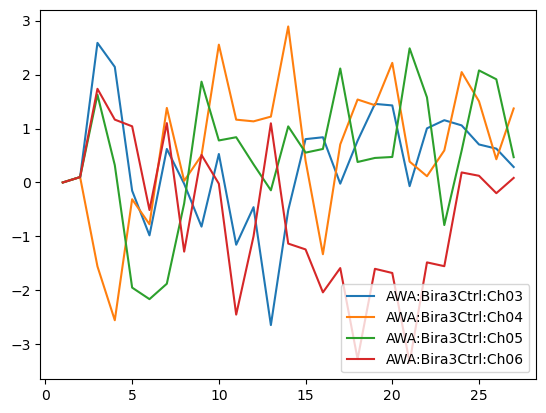

In [15]:
X.data.plot(y=X.vocs.variable_names[:4])

<Axes: >

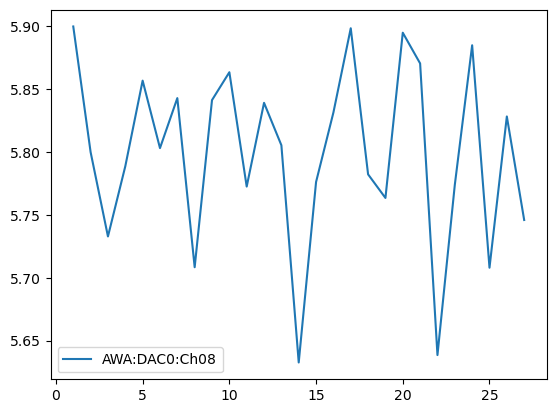

In [16]:
X.data.plot(y=X.vocs.variable_names[4])

<Axes: >

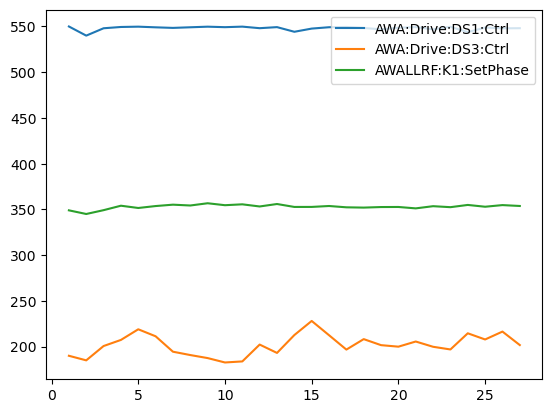

In [17]:
X.data.plot(y=X.vocs.variable_names[5:])

<Axes: >

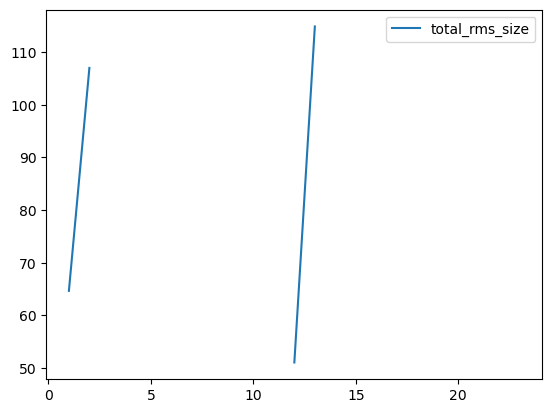

In [18]:
X.data.plot(y=X.vocs.objective_names)

In [19]:
# get best point
X.data.iloc[np.nanargmin(X.data[vocs.objective_names].to_numpy())]

AWA:Bira3Ctrl:Ch03                      -0.457727
AWA:Bira3Ctrl:Ch04                       1.132808
AWA:Bira3Ctrl:Ch05                       0.336093
AWA:Bira3Ctrl:Ch06                      -0.997545
AWA:DAC0:Ch08                            5.839219
AWA:Drive:DS1:Ctrl                      548.13037
AWA:Drive:DS3:Ctrl                     202.253609
AWALLRF:K1:SetPhase                    353.228472
AWAVXI11ICT:Ch1                               0.0
13ARV1:image1:ArraySize1_RBV               1200.0
13ARV1:image1:ArraySize0_RBV               1920.0
13ARV1:Cx                              354.246577
13ARV1:Cy                               289.80054
13ARV1:Sx                               48.911549
13ARV1:Sy                               14.653545
13ARV1:bb_penalty                     -142.872865
13ARV1:total_intensity                  2182048.6
13ARV1:log10_total_intensity             6.335585
AWAVXI11ICT:Ch1_std                           0.0
13ARV1:image1:ArraySize1_RBV_std              0.0
